# DIMENSIONALITY REDUCTION
A notebook to reduce the dimensions of player data

In [46]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [47]:
# Where to save the figures
NOTE_ROOT_DIR = os.path.abspath('')
CHAPTER_ID = "02.5_dimensionality_reduction"
IMAGES_PATH = os.path.join(NOTE_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [48]:
# Setup for KMeans on reduced axes
from sklearn.cluster import KMeans

def kmeans_scores(feats, n_clusters, axis):
    scores=[]
    for i in range(1, n_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(feats[:, axis].reshape(-1, 1))
        scores.append(kmeans.inertia_)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, n_clusters+1), scores)
    plt.xlabel('number of clusters')
    plt.ylabel('inertia')
    plt.xticks(list(range(1, n_clusters+1)))
    plt.title(f'Elbow Method on C{axis}')
    plt.grid()
    plt.tight_layout()

def cluster_plot(feats, n_clusters, axis):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster = kmeans.fit_predict(feats[:, axis].reshape(-1, 1))
    colors = plt.cm.BuPu(np.linspace(0.5, 1, len(np.unique(cluster))))
    cmap = {i: colors[i] for i in range(len(colors))}
    
    plt.subplots(1, 1, figsize=(14,6))
    sc = plt.scatter(np.arange(0, len(feats)), feats[:, axis], 
                     c=pd.Series(cluster).map(cmap), alpha=0.5)
    plt.xlabel('player index')
    plt.ylabel(f"C{axis}")
    plt.grid(True)
    plt.tight_layout()
    return cluster

def clusters_info(positions, clusters):
    record = pd.DataFrame(index=[0, 1, 2, 3])
    record_percent = pd.DataFrame(index=[0, 1, 2, 3])
    pos = ["df", "fw", "gk", "mf"]
    
    total_unique, total_counts = np.unique(positions, return_counts=True)
    total_counts = total_counts[np.argsort(total_unique)]
    for cluster in np.unique(clusters):
        position = positions[np.where(clusters == cluster)]
        unique, counts = np.unique(position, return_counts=True)
        record[cluster] = pd.Series(counts, index=unique)
        record_percent[cluster] = np.round(record[cluster] * 100 / total_counts, 2)
    
    record["pos"] = pos
    record_percent["pos"] = pos
    return {"percent": record_percent.fillna(0.0).set_index("pos"), "count": record.fillna(0.0).set_index("pos")}

In [49]:
# Setup for Gaussian Mixtures (if needed)
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture

def gaumix_scores(feats, n_clusters, axis):
    scores = []
    for i in range(2, n_clusters+1):
        gaumix = GaussianMixture(n_components=i, random_state=42)
        y_pred = gaumix.fit_predict(feats[:, axis].reshape(-1, 1))
        scores.append(silhouette_score(feats[:, axis].reshape(-1, 1), y_pred))
    plt.figure(figsize=(12, 6))
    plt.plot(range(2, n_clusters+1), scores)
    plt.xlabel('number of clusters')
    plt.ylabel('silhouette score')
    plt.xticks(list(range(1, n_clusters+1)))
    plt.title(f'Elbow Method on C{axis}')
    plt.grid()
    plt.tight_layout()

def gaumix_cluster_plot(feats, n_clusters, axis):
    gaumix = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster = gaumix.fit_predict(feats[:, axis].reshape(-1, 1))
    colors = plt.cm.BuPu(np.linspace(0.5, 1, len(np.unique(cluster))))
    cmap = {i: colors[i] for i in range(len(colors))}
    
    plt.subplots(1, 1, figsize=(14,6))
    sc = plt.scatter(np.arange(0, len(feats)), feats[:, axis], 
                     c=pd.Series(cluster).map(cmap), alpha=0.5)
    plt.xlabel('player index')
    plt.ylabel(f"C{axis}")
    plt.grid(True)
    plt.tight_layout()
    return cluster

## 1 - Load the Data

In [50]:
# Load player data with position
df_player = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "exploratory", "players_with_position.csv"))
df_player.head()

,defence/clean_sheets,defence/goals_conceded,defence/tackles,defence/tackle_success_%,defence/last_man_tackles,defence/blocked_shots,defence/interceptions,defence/clearances,defence/headed_clearance,defence/clearances_off_line,defence/successful_50/50s,defence/aerial_battles_won,defence/aerial_battles_lost,defence/own_goals,defence/errors_leading_to_goal,teamplay/goals,teamplay/assists,teamplay/passes_per_match,teamplay/big_chances_created,teamplay/cross_accuracy_%,teamplay/through_balls,discipline/yellow_cards,discipline/red_cards,discipline/fouls,discipline/offsides,attack/goals,attack/goals_per_match,attack/headed_goals,attack/goals_with_right_foot,attack/goals_with_left_foot,attack/penalties_scored,attack/freekicks_scored,attack/shots,attack/shots_on_target,attack/shooting_accuracy_%,attack/hit_woodwork,attack/big_chances_missed,goalkeeping/saves,goalkeeping/penalties_saved,goalkeeping/punches,goalkeeping/high_claims,goalkeeping/catches,goalkeeping/sweeper_clearances,goalkeeping/throw_outs,goalkeeping/goal_kicks,defence/recoveries,defence/duels_won,defence/duels_lost,teamplay/passes,teamplay/crosses,teamplay/accurate_long_balls,id,name,season,position
0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,14.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.06,3.0,0.0,0.0,1.0,0.0,18.0,10.0,1.0,0.06,1.0,0.0,0.0,0.0,0.0,26.0,8.0,31.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241.0,1.0,0.0,54861.0,Christian Benteke,2018/19,fw
1,0.0,0.0,49.0,0.0,0.0,9.0,27.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.71,4.0,0.0,0.0,5.0,0.0,17.0,2.0,1.0,0.03,0.0,1.0,0.0,0.0,0.0,23.0,5.0,22.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.0,51.0,0.0,100649.0,Bernard,2018/19,mf
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217401.0,Josh Benson,2018/19,mf
3,0.0,3.0,1.0,100.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,33.00,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,5.0,33.0,0.0,1.0,83312.0,Ben Gibson,2018/19,df
4,5.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,22.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,4.0,19.0,5.0,8.0,128.0,192.0,0.0,0.0,0.0,530.0,0.0,137.0,40349.0,Asmir Begovic,2018/19,gk


In [51]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
df_player['position'] = LabelEncoder().fit_transform(df_player['position'])
df_player = df_player[df_player["season"] != "2018/19"]
df_player.head()

,defence/clean_sheets,defence/goals_conceded,defence/tackles,defence/tackle_success_%,defence/last_man_tackles,defence/blocked_shots,defence/interceptions,defence/clearances,defence/headed_clearance,defence/clearances_off_line,defence/successful_50/50s,defence/aerial_battles_won,defence/aerial_battles_lost,defence/own_goals,defence/errors_leading_to_goal,teamplay/goals,teamplay/assists,teamplay/passes_per_match,teamplay/big_chances_created,teamplay/cross_accuracy_%,teamplay/through_balls,discipline/yellow_cards,discipline/red_cards,discipline/fouls,discipline/offsides,attack/goals,attack/goals_per_match,attack/headed_goals,attack/goals_with_right_foot,attack/goals_with_left_foot,attack/penalties_scored,attack/freekicks_scored,attack/shots,attack/shots_on_target,attack/shooting_accuracy_%,attack/hit_woodwork,attack/big_chances_missed,goalkeeping/saves,goalkeeping/penalties_saved,goalkeeping/punches,goalkeeping/high_claims,goalkeeping/catches,goalkeeping/sweeper_clearances,goalkeeping/throw_outs,goalkeeping/goal_kicks,defence/recoveries,defence/duels_won,defence/duels_lost,teamplay/passes,teamplay/crosses,teamplay/accurate_long_balls,id,name,season,position
7,0.0,0.0,12.0,50.0,0.0,6.0,8.0,5.0,4.0,0.0,19.0,20.0,31.0,0.0,0.0,0.0,1.0,9.10,0.0,9.0,2.0,0.0,0.0,8.0,7.0,7.0,0.23,1.0,4.0,2.0,0.0,0.0,32.0,13.0,41.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,73.0,71.0,273.0,11.0,5.0,216646.0,Yoane Wissa,2021/22,1
8,0.0,0.0,17.0,0.0,0.0,5.0,6.0,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,21.30,2.0,0.0,0.0,3.0,0.0,30.0,9.0,2.0,0.10,1.0,1.0,0.0,0.0,0.0,30.0,9.0,30.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,426.0,4.0,0.0,120202.0,Wout Weghorst,2021/22,1
9,5.0,22.0,28.0,68.0,0.0,3.0,18.0,78.0,46.0,0.0,2.0,56.0,20.0,0.0,0.0,0.0,1.0,52.32,1.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,92.0,38.0,1151.0,1.0,80.0,90152.0,Raphaël Varane,2021/22,0
10,0.0,0.0,5.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.86,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,6.0,2.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,7.0,0.0,439509.0,Christos Tzolis,2021/22,3
11,0.0,0.0,3.0,67.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,3.0,9.0,0.0,0.0,0.0,0.0,16.43,0.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,9.0,28.0,115.0,7.0,3.0,130036.0,Ozan Tufan,2021/22,3


**NOTE:** 1 - FW, 2 - GK, 3 - MF, 0 - DF.

In [52]:
# Split train-test data
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_player, test_size=0.1, random_state=42)
X_test, y_test = test_set.iloc[:, :-4], test_set["position"]
X_train, y_train = train_set.iloc[:, :-4], train_set["position"]
X_train.head()

,defence/clean_sheets,defence/goals_conceded,defence/tackles,defence/tackle_success_%,defence/last_man_tackles,defence/blocked_shots,defence/interceptions,defence/clearances,defence/headed_clearance,defence/clearances_off_line,defence/successful_50/50s,defence/aerial_battles_won,defence/aerial_battles_lost,defence/own_goals,defence/errors_leading_to_goal,teamplay/goals,teamplay/assists,teamplay/passes_per_match,teamplay/big_chances_created,teamplay/cross_accuracy_%,teamplay/through_balls,discipline/yellow_cards,discipline/red_cards,discipline/fouls,discipline/offsides,attack/goals,attack/goals_per_match,attack/headed_goals,attack/goals_with_right_foot,attack/goals_with_left_foot,attack/penalties_scored,attack/freekicks_scored,attack/shots,attack/shots_on_target,attack/shooting_accuracy_%,attack/hit_woodwork,attack/big_chances_missed,goalkeeping/saves,goalkeeping/penalties_saved,goalkeeping/punches,goalkeeping/high_claims,goalkeeping/catches,goalkeeping/sweeper_clearances,goalkeeping/throw_outs,goalkeeping/goal_kicks,defence/recoveries,defence/duels_won,defence/duels_lost,teamplay/passes,teamplay/crosses,teamplay/accurate_long_balls
1193,0.0,0.0,15.0,0.0,0.0,6.0,6.0,29.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.13,1.0,0.0,0.0,2.0,0.0,24.0,4.0,1.0,0.04,1.0,0.0,0.0,0.0,0.0,30.0,13.0,43.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,4.0,0.0
170,0.0,0.0,3.0,0.0,0.0,1.0,2.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.11,0.0,0.0,0.0,2.0,0.0,11.0,2.0,1.0,0.11,0.0,1.0,0.0,0.0,0.0,7.0,4.0,57.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,2.0,0.0
679,0.0,0.0,8.0,0.0,0.0,17.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.71,0.0,0.0,0.0,1.0,0.0,11.0,11.0,4.0,0.19,0.0,2.0,2.0,0.0,0.0,45.0,16.0,36.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372.0,23.0,0.0
1767,4.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,30.92,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,1.0,6.0,17.0,3.0,7.0,76.0,223.0,0.0,0.0,0.0,804.0,0.0,213.0
1398,0.0,0.0,22.0,64.0,0.0,0.0,17.0,8.0,3.0,0.0,4.0,6.0,8.0,0.0,1.0,0.0,0.0,21.92,0.0,0.0,0.0,3.0,0.0,8.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,42.0,23.0,285.0,1.0,8.0


## 2 -  Linear Discriminant Analysis (LDA)

### Fit method to the Dataset

In [53]:
# Fit LDA to the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lda = Pipeline([
    ("scaler", StandardScaler()),
    ("dim_reductor", LDA(n_components=3))
])
X_lda = lda.fit_transform(X_train, y_train)
lda["dim_reductor"].explained_variance_ratio_

array([0.49436953, 0.41294521, 0.09268525])

Saving figure lda_feature_space


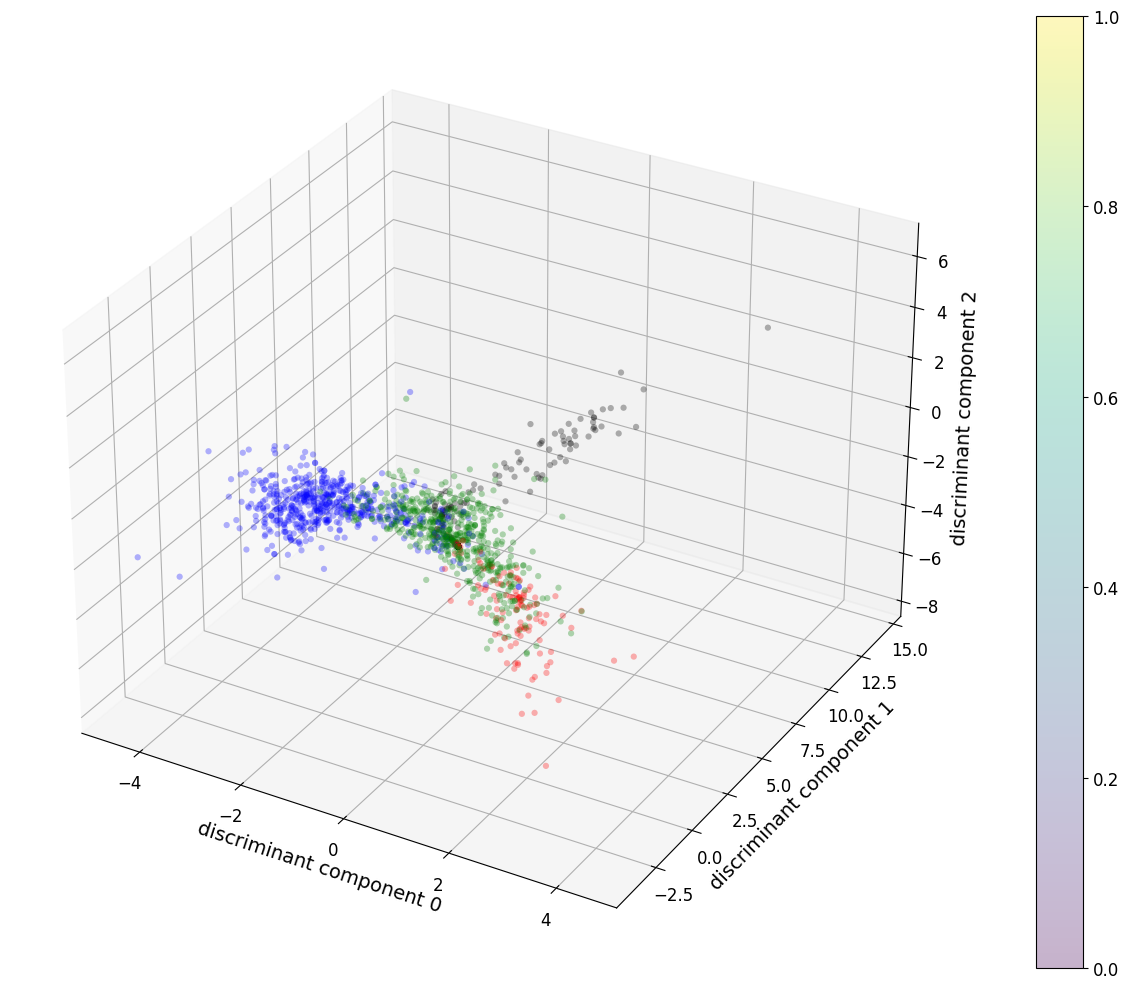

In [264]:
# Plot the feature space with position colored
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
p=ax.scatter3D(xs=X_lda[:, 0], ys=X_lda[:, 1], zs=X_lda[:, 2],
               c=y_train.map({0:'blue',1:'r',2:'black', 3:'g'}), edgecolor='none', alpha=0.3)
ax.set_xlabel('discriminant component 0')
ax.set_ylabel('discriminant component 1')
ax.set_zlabel('discriminant component 2')
plt.colorbar(p)
save_fig("lda_feature_space")

**NOTE:** We could see clearly the separate regions for each position, which means LDA could possibly fit well with this dataset.

In [54]:
# Test the LDA (accuracy)
lda.score(X_test, y_test)

0.7393617021276596

### Clustering on the Axes

#### First Discriminant Component (C0)

Saving figure kmeans_elbow_c0


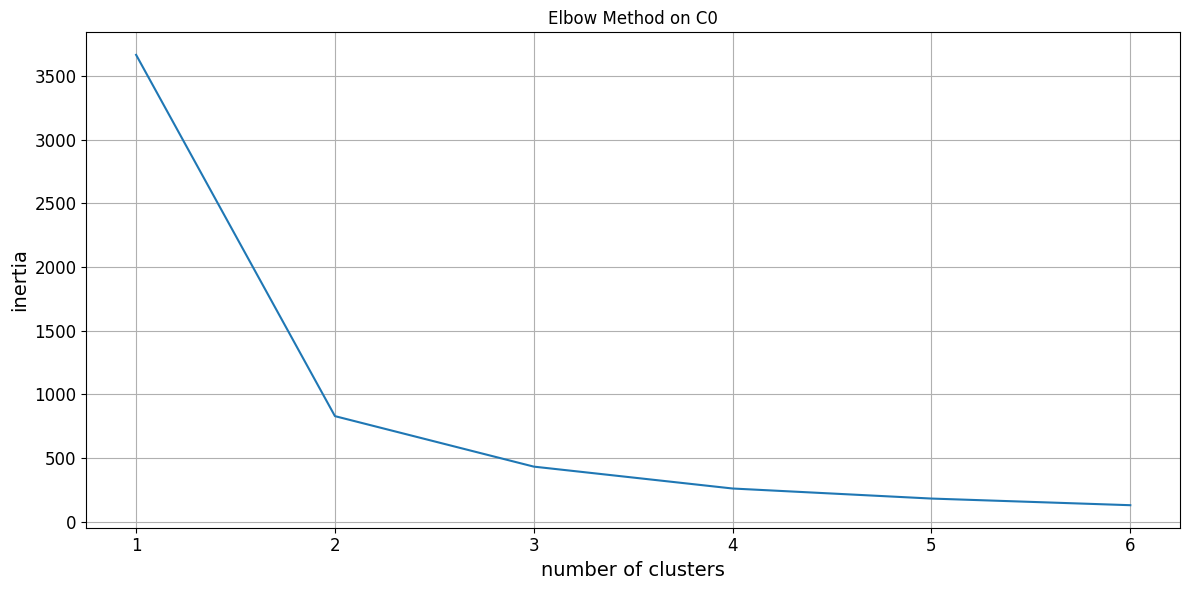

In [326]:
# KMeans' elbow on 1st DC
kmeans_scores(X_lda, 6, 0)
save_fig("kmeans_elbow_c0")

Saving figure kmeans_cluster_c0


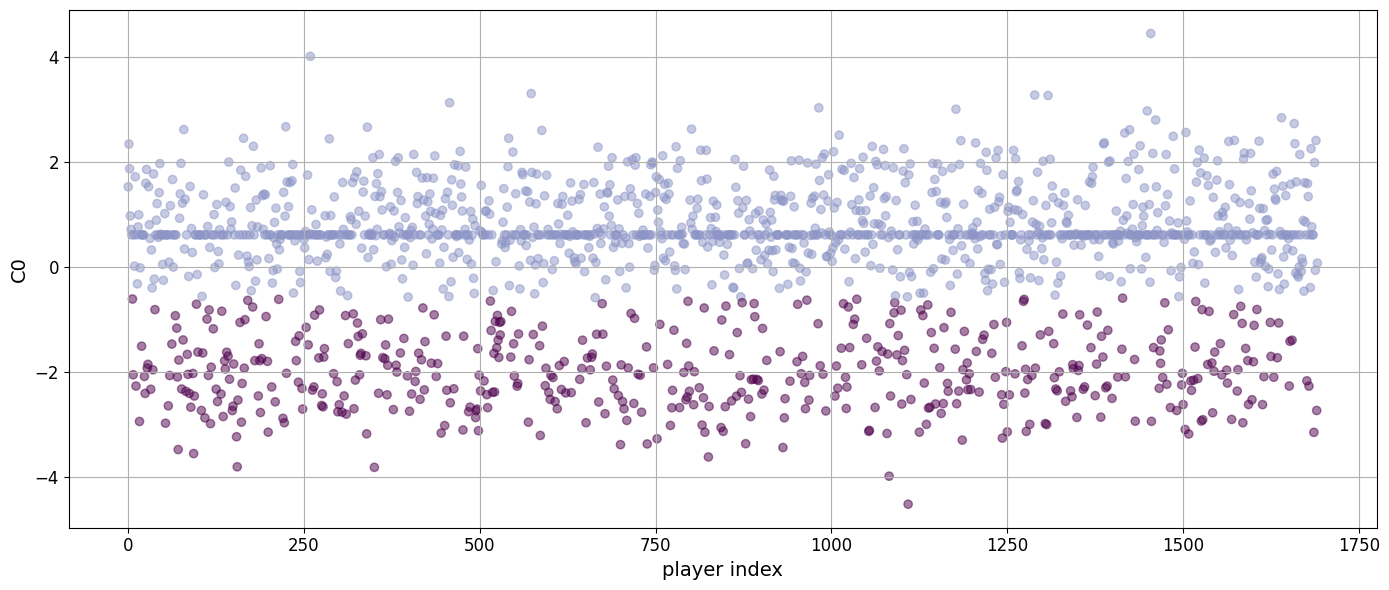

In [319]:
# Plot cluster by KMeans
cluster_c1 = cluster_plot(X_lda, 2, 0)
save_fig("kmeans_cluster_c0")

**NOTE:** Higher cluster, more dense color.

In [268]:
# How many roles in each cluster (percent per role)
clusters_info(y_train.values, cluster_c1)["percent"]

,0,1
pos,,
df,29.79,70.21
fw,100.00,0.00
gk,100.00,0.00
mf,95.40,4.60


In [269]:
# How many roles in each cluster (count per role)
clusters_info(y_train.values, cluster_c1)["count"]

,0,1
pos,,
df,199,469.0
fw,184,0.0
gk,144,0.0
mf,664,32.0


**NOTE:** The first component is intuitively able to rank goalkeepers, fowards, midfields since they are all on the same cluster. Only defender role crosses over the range of `C0`, which could point out difference between defenders and vice versa. Therefore, we possibly take this component (`C0`) for arranging defenders in integration.

#### Second Discriminant Component (C1)

Saving figure kmeans_elbow_c1


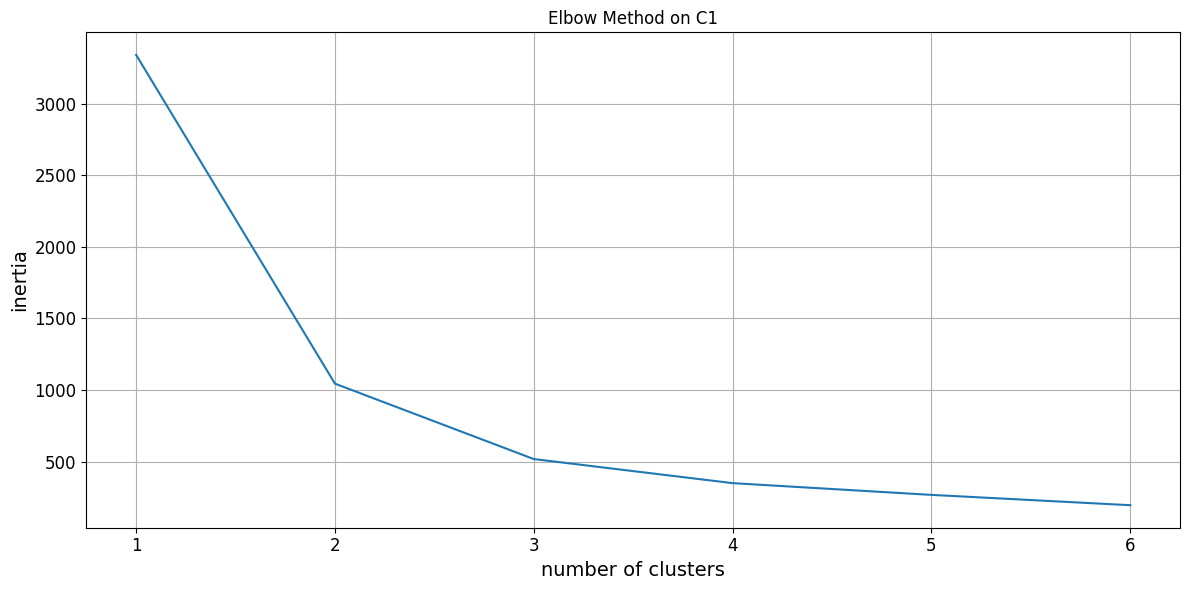

In [325]:
# KMeans' elbow on 2nd DC
kmeans_scores(X_lda, 6, 1)
save_fig("kmeans_elbow_c1")

Saving figure kmeans_cluster_c1


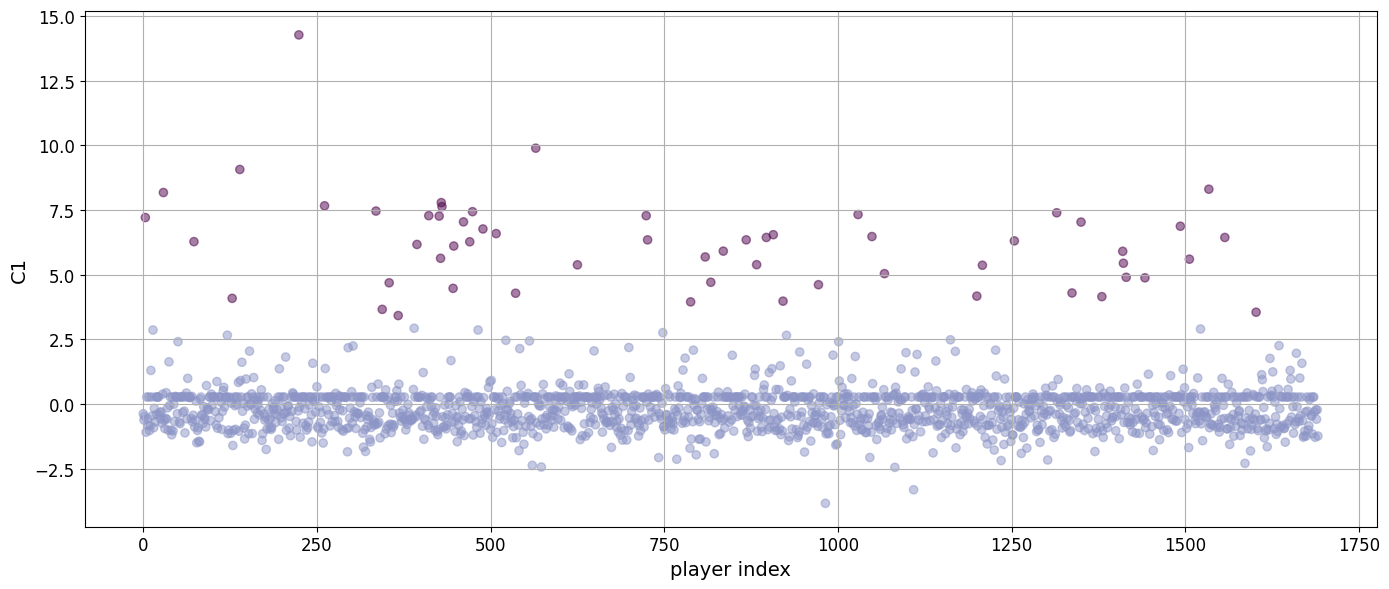

In [321]:
# Plot cluster by KMeans
cluster_c2 = cluster_plot(X_lda, 2, 1)
save_fig("kmeans_cluster_c1")

In [272]:
# How many roles in each cluster (percent per role)
clusters_info(y_train.values, cluster_c2)["percent"]

,0,1
pos,,
df,100.00,0.00
fw,100.00,0.00
gk,59.72,40.28
mf,100.00,0.00


In [273]:
# How many roles in each cluster (count per role)
clusters_info(y_train.values, cluster_c2)["count"]

,0,1
pos,,
df,668,0.0
fw,184,0.0
gk,86,58.0
mf,696,0.0


**NOTE:** The second component is intuitively not able to describe defenders, forwards, midfields but just the goalkeepers.

#### Third Discriminant Component (C2)

Saving figure kmeans_elvow_c2


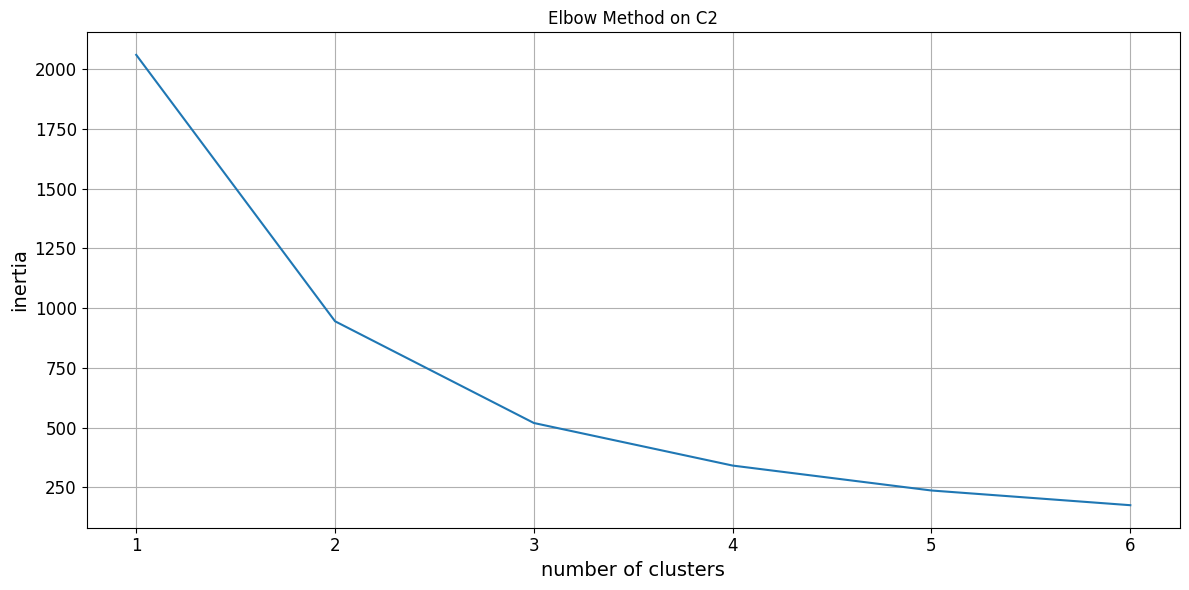

In [324]:
# KMeans' elbow on 2nd DC
kmeans_scores(X_lda, 6, 2)
save_fig("kmeans_elvow_c2")

Saving figure kmeans_cluster_c2


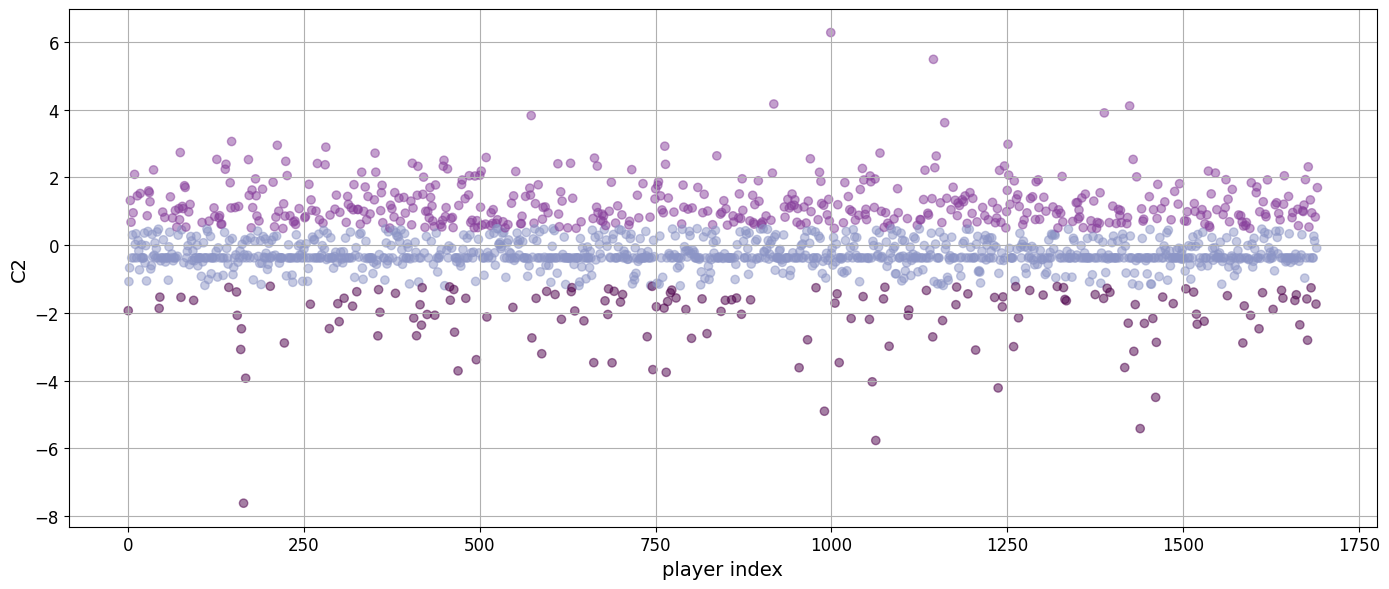

In [323]:
# Plot cluster by KMeans (2 cluster)
cluster_c3 = cluster_plot(X_lda, 3, 2)
save_fig("kmeans_cluster_c2")

In [279]:
# How many roles in each cluster (percent per role)
clusters_info(y_train.values, cluster_c3)["percent"]

,0,1,2
pos,,,
df,72.01,19.76,8.23
fw,63.04,1.09,35.87
gk,70.83,29.17,0.00
mf,50.72,44.83,4.45


In [280]:
# How many roles in each cluster (count per role)
clusters_info(y_train.values, cluster_c3)["count"]

,0,1,2
pos,,,
df,481,132,55.0
fw,116,2,66.0
gk,102,42,0.0
mf,353,312,31.0


**NOTE:** Since this component just explains a little variance (~1%), then we will consider other columns more clearly intuitive.

#### Comprise C0 & C1 

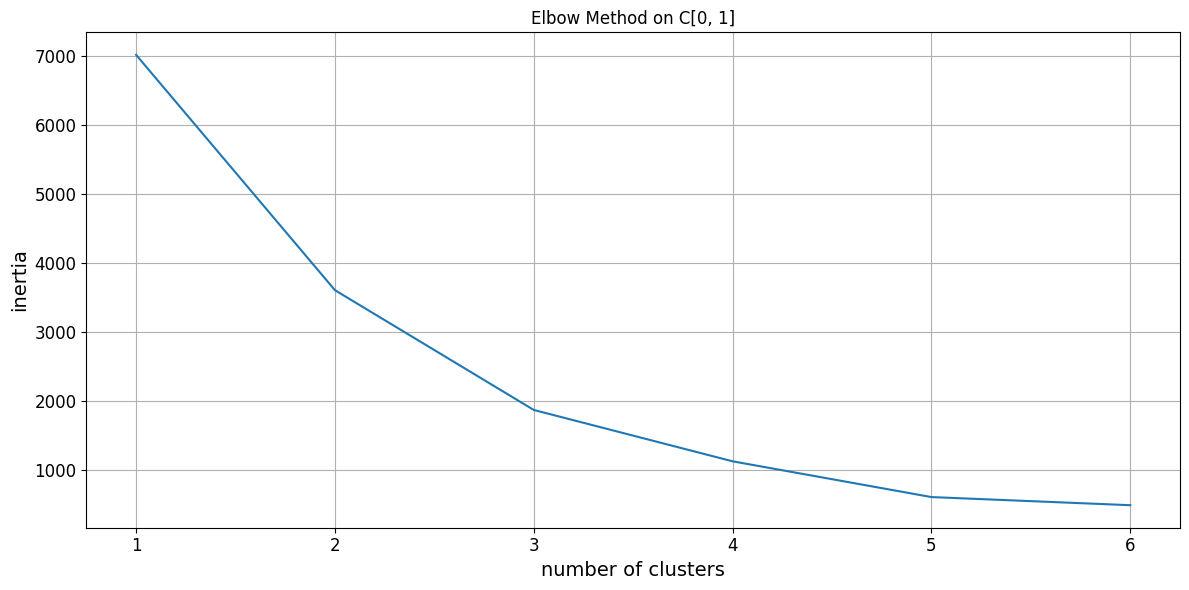

In [327]:
# KMeans' elbow on the two first DCs
kmeans_scores(X_lda, 6, [0, 1])

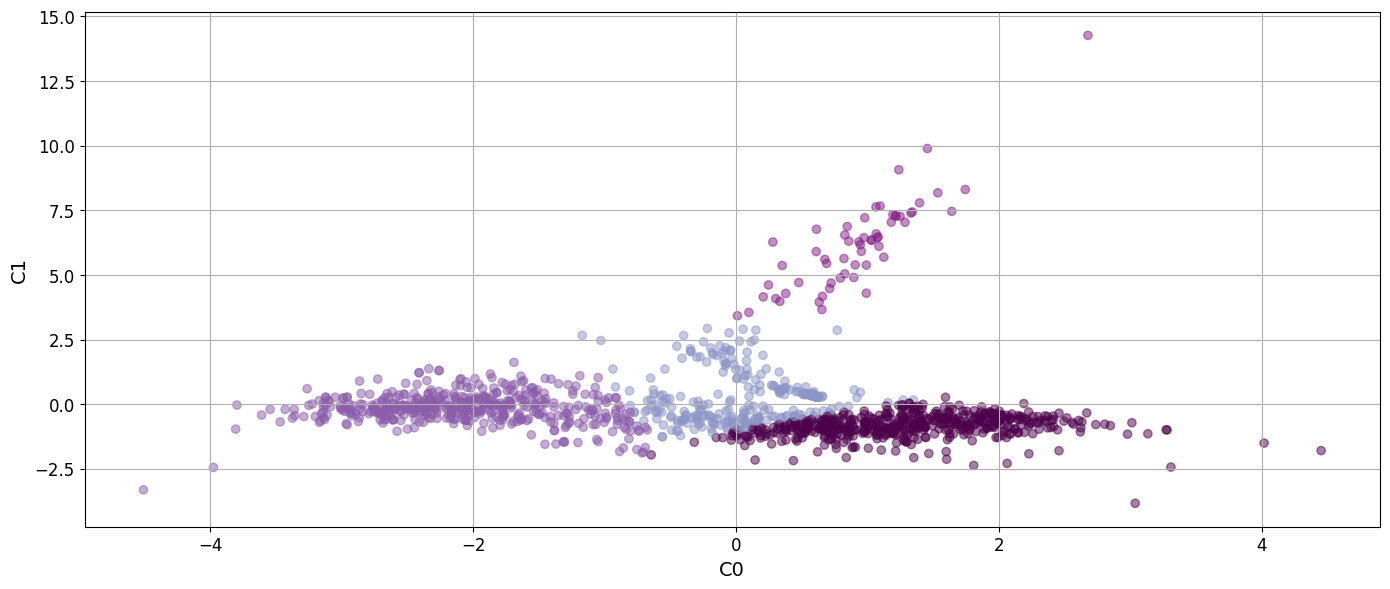

In [352]:
# Plot cluster by KMeans (4 cluster)
def cluster_plot(feats, n_clusters, axes):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster = kmeans.fit_predict(feats[:, axes])
    colors = plt.cm.BuPu(np.linspace(0.5, 1, len(np.unique(cluster))))
    cmap = {i: colors[i] for i in range(len(colors))}
    
    plt.subplots(1, 1, figsize=(14,6))
    sc = plt.scatter(feats[:, axes[0]], feats[:, axes[1]], 
                     c=pd.Series(cluster).map(cmap), alpha=0.5)
    plt.xlabel(f'C{axes[0]}')
    plt.ylabel(f"C{axes[1]}")
    plt.grid(True)
    plt.tight_layout()
    return cluster

cluster_c01 = cluster_plot(X_lda, 4, [0, 1])

In [350]:
# How many roles in each cluster (percent per role)
clusters_info(y_train.values, cluster_c01)["percent"]

,0,1,2,3
pos,,,,
df,25.45,67.96,0.00,6.59
fw,41.30,0.00,0.00,58.70
gk,59.72,0.00,40.28,0.00
mf,41.24,3.45,0.00,55.32


In [351]:
# How many roles in each cluster (count per role)
clusters_info(y_train.values, cluster_c01)["count"]

,0,1,2,3
pos,,,,
df,170,454.0,0.0,44.0
fw,76,0.0,0.0,108.0
gk,86,0.0,58.0,0.0
mf,287,24.0,0.0,385.0


### Correlation with Original Features

Saving figure performance_corr_components


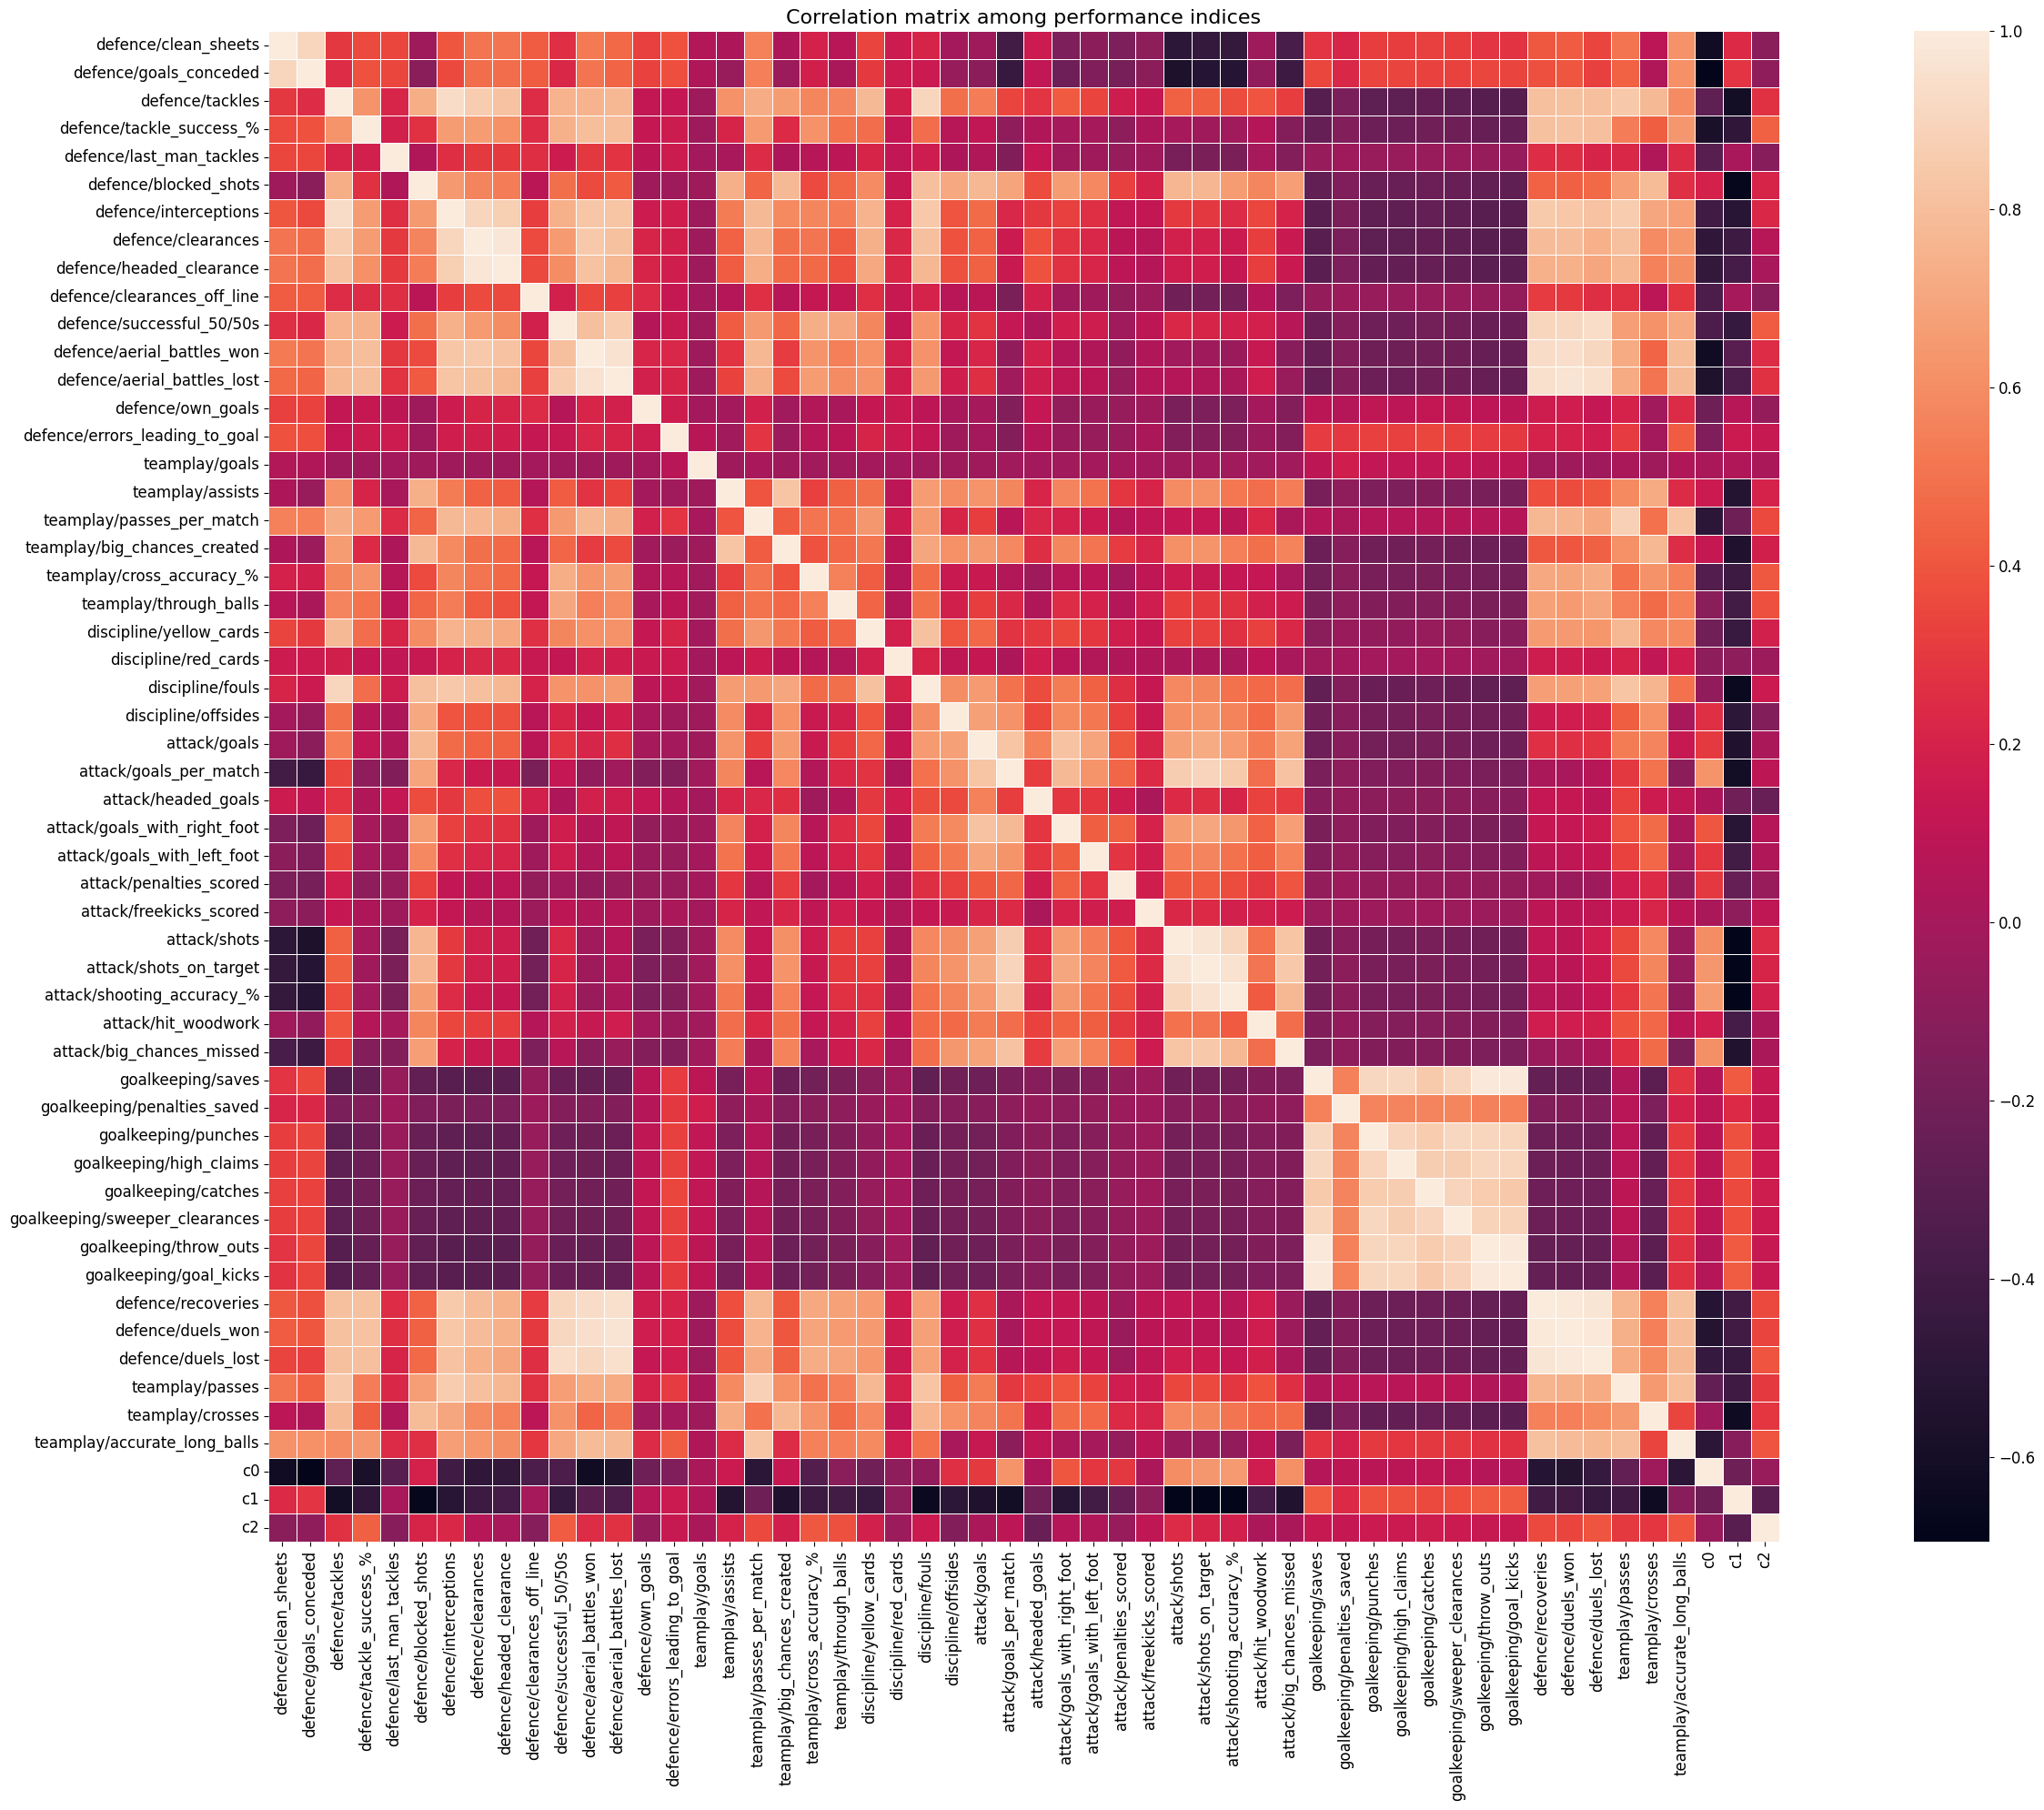

In [317]:
# Correlation among performance indices of players
X_argu = X_train.copy()
X_argu["c0"] = X_lda[:, 0]
X_argu["c1"] = X_lda[:, 1]
X_argu["c2"] = X_lda[:, 2]
corr_mat = X_argu.corr(method="spearman")

plt.figure(figsize=(30, 20))
sns.heatmap(corr_mat, square=True, annot=False, linewidths=.5)
plt.title("Correlation matrix among performance indices", size=16)
plt.tight_layout()
save_fig("performance_corr_components")

In [313]:
# Get the most correlated pairs of indices
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

tri_corr_mat = corr_mat.unstack()
cells_to_drop = get_redundant_pairs(X_argu)
tri_corr_mat = tri_corr_mat.drop(labels=cells_to_drop).sort_values(ascending=False)

#### First Discriminant Component (C0)

In [314]:
# Get the most correlated pairs of indices with C0
corr_mat_c0 = tri_corr_mat.iloc[tri_corr_mat.index.get_level_values(0).str.contains("c0") | tri_corr_mat.index.get_level_values(1).str.contains("c0")]

print("Top 10 positive correlated feature pairs:\n" + str(corr_mat_c0[0:10]))
print("\n----------------------------------------------------------------")
print("\nTop 10 negative correlated feature pairs:\n"+ str(corr_mat_c0[-10:]))
print("\n----------------------------------------------------------------")
print("\nTop 10 feature pairs:\n" + str(corr_mat_c0.abs().sort_values(ascending=False)[:10]))

Top 10 positive correlated feature pairs:
attack/shooting_accuracy_%    c0    0.652245
attack/shots_on_target        c0    0.639913
attack/goals_per_match        c0    0.628009
attack/big_chances_missed     c0    0.603380
attack/shots                  c0    0.600812
attack/goals_with_right_foot  c0    0.400749
attack/goals                  c0    0.301212
attack/penalties_scored       c0    0.292553
attack/goals_with_left_foot   c0    0.286656
discipline/offsides           c0    0.263404
dtype: float64

----------------------------------------------------------------

Top 10 negative correlated feature pairs:
defence/clearances            c0   -0.481238
teamplay/accurate_long_balls  c0   -0.496044
teamplay/passes_per_match     c0   -0.498645
defence/recoveries            c0   -0.525667
defence/duels_won             c0   -0.530347
defence/aerial_battles_lost   c0   -0.556094
defence/tackle_success_%      c0   -0.576424
defence/clean_sheets          c0   -0.615810
defence/aerial_battles_w

**NOTE:** As expected, `C0` moderately correlates with `defence`. More interestingly, `C0` also highly correlates with `attack`, which means `C0` could be used to estimate the performance of `fw`.

#### Second Discriminant Component (C1)

In [315]:
# Get the most correlated pairs of indices with C1
corr_mat_c1 = tri_corr_mat.iloc[tri_corr_mat.index.get_level_values(0).str.contains("c1") | tri_corr_mat.index.get_level_values(1).str.contains("c1")]

print("Top 10 positive correlated feature pairs:\n" + str(corr_mat_c1[0:10]))
print("\n----------------------------------------------------------------")
print("\nTop 10 negative correlated feature pairs:\n"+ str(corr_mat_c1[-10:]))
print("\n----------------------------------------------------------------")
print("\nTop 10 feature pairs:\n" + str(corr_mat_c1.abs().sort_values(ascending=False)[:10]))

Top 10 positive correlated feature pairs:
goalkeeping/goal_kicks          c1    0.420425
goalkeeping/saves               c1    0.417096
goalkeeping/throw_outs          c1    0.417071
goalkeeping/punches             c1    0.381669
goalkeeping/high_claims         c1    0.380515
goalkeeping/sweeper_clearances  c1    0.376629
goalkeeping/catches             c1    0.356813
defence/goals_conceded          c1    0.279545
defence/clean_sheets            c1    0.237706
goalkeeping/penalties_saved     c1    0.233023
dtype: float64

----------------------------------------------------------------

Top 10 negative correlated feature pairs:
attack/goals                  c1   -0.551457
teamplay/big_chances_created  c1   -0.555376
attack/goals_per_match        c1   -0.609035
defence/tackles               c1   -0.609916
teamplay/crosses              c1   -0.632375
discipline/fouls              c1   -0.641934
defence/blocked_shots         c1   -0.668863
attack/shooting_accuracy_%    c1   -0.688786
atta

**NOTE:** As expected, `C1` moderately correlates with `goalkeeping`. More interestingly, `C1` also highly correlates with `attack` and features relevant to goal opportunities, which means `C1` could also be used to classify `mf`.

#### Third Discriminant Component (C2)

In [316]:
# Get the most correlated pairs of indices with C2
corr_mat_c2 = tri_corr_mat.iloc[tri_corr_mat.index.get_level_values(0).str.contains("c2") | tri_corr_mat.index.get_level_values(1).str.contains("c2")]

print("Top 10 positive correlated feature pairs:\n" + str(corr_mat_c2[0:10]))
print("\n----------------------------------------------------------------")
print("\nTop 10 negative correlated feature pairs:\n"+ str(corr_mat_c2[-10:]))
print("\n----------------------------------------------------------------")
print("\nTop 10 feature pairs:\n" + str(corr_mat_c2.abs().sort_values(ascending=False)[:10]))

Top 10 positive correlated feature pairs:
defence/tackle_success_%      c2    0.436876
defence/successful_50/50s     c2    0.423316
teamplay/cross_accuracy_%     c2    0.409436
teamplay/accurate_long_balls  c2    0.397458
defence/duels_lost            c2    0.394433
teamplay/through_balls        c2    0.383968
teamplay/passes_per_match     c2    0.356084
defence/recoveries            c2    0.354900
defence/duels_won             c2    0.342282
teamplay/passes               c2    0.299243
dtype: float64

----------------------------------------------------------------

Top 10 negative correlated feature pairs:
attack/penalties_scored      c2   -0.046253
c0                           c2   -0.048849
defence/own_goals            c2   -0.061596
defence/goals_conceded       c2   -0.079928
defence/clean_sheets         c2   -0.105755
defence/last_man_tackles     c2   -0.112080
defence/clearances_off_line  c2   -0.122931
discipline/offsides          c2   -0.136933
attack/headed_goals          c2 

**NOTE:** As above concluded, this axis explains much less variance, so the insights about it will only be used when other methods produce unclear results.

### Save the Work

In [65]:
# Load player data with position
df_player_nopos = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "clean", "players.csv"))
df_player_nopos.head()

,defence/clean_sheets,defence/goals_conceded,defence/tackles,defence/tackle_success_%,defence/last_man_tackles,defence/blocked_shots,defence/interceptions,defence/clearances,defence/headed_clearance,defence/clearances_off_line,defence/successful_50/50s,defence/aerial_battles_won,defence/aerial_battles_lost,defence/own_goals,defence/errors_leading_to_goal,teamplay/goals,teamplay/assists,teamplay/passes_per_match,teamplay/big_chances_created,teamplay/cross_accuracy_%,teamplay/through_balls,discipline/yellow_cards,discipline/red_cards,discipline/fouls,discipline/offsides,attack/goals,attack/goals_per_match,attack/headed_goals,attack/goals_with_right_foot,attack/goals_with_left_foot,attack/penalties_scored,attack/freekicks_scored,attack/shots,attack/shots_on_target,attack/shooting_accuracy_%,attack/hit_woodwork,attack/big_chances_missed,goalkeeping/saves,goalkeeping/penalties_saved,goalkeeping/punches,goalkeeping/high_claims,goalkeeping/catches,goalkeeping/sweeper_clearances,goalkeeping/throw_outs,goalkeeping/goal_kicks,defence/recoveries,defence/duels_won,defence/duels_lost,teamplay/passes,teamplay/crosses,teamplay/accurate_long_balls,id,name,season
0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,14.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.06,3.0,0.0,0.0,1.0,0.0,18.0,10.0,1.0,0.06,1.0,0.0,0.0,0.0,0.0,26.0,8.0,31.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241.0,1.0,0.0,54861.0,Christian Benteke,2018/19
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213405.0,Filip Benkovic,2018/19
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449926.0,Adrián Bernabé,2018/19
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182436.0,Ben Woodburn,2018/19
4,0.0,0.0,49.0,0.0,0.0,9.0,27.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.71,4.0,0.0,0.0,5.0,0.0,17.0,2.0,1.0,0.03,0.0,1.0,0.0,0.0,0.0,23.0,5.0,22.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.0,51.0,0.0,100649.0,Bernard,2018/19


In [70]:
# Transform full player data
df_player_nopos_lda = pd.DataFrame(lda.transform(df_player_nopos.iloc[:, :-3]), index=df_player_nopos.index)
df_player_nopos_lda[["id", "name", "season"]] = df_player_nopos[["id", "name", "season"]]
df_player_nopos_lda.head()

,0,1,2,id,name,season
0,1.687741,-0.155813,-2.664956,54861.0,Christian Benteke,2018/19
1,0.619076,0.274014,-0.376937,213405.0,Filip Benkovic,2018/19
2,0.619076,0.274014,-0.376937,449926.0,Adrián Bernabé,2018/19
3,0.619076,0.274014,-0.376937,182436.0,Ben Woodburn,2018/19
4,0.511864,-0.831793,1.503204,100649.0,Bernard,2018/19


In [55]:
# Where to save dataframe
def save_df(df, path, extension="csv", index=False):
    df.to_csv(path, index=index)

In [72]:
# Save the final data
save_df(df_player_nopos_lda, os.path.join(PRJ_ROOT_DIR, "data", "tabular", "exploratory", "players_lda.csv"))

## 3 - T-SNE

In [29]:
# Fit TSNE to the data
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

tsne = Pipeline([
    ("scaler", StandardScaler()),
    ("dim_reductor", TSNE(n_components=3))
])

X_tsne = tsne.fit_transform(X_train)
X_tsne.shape

(1840, 3)

Saving figure tsne_feature_space


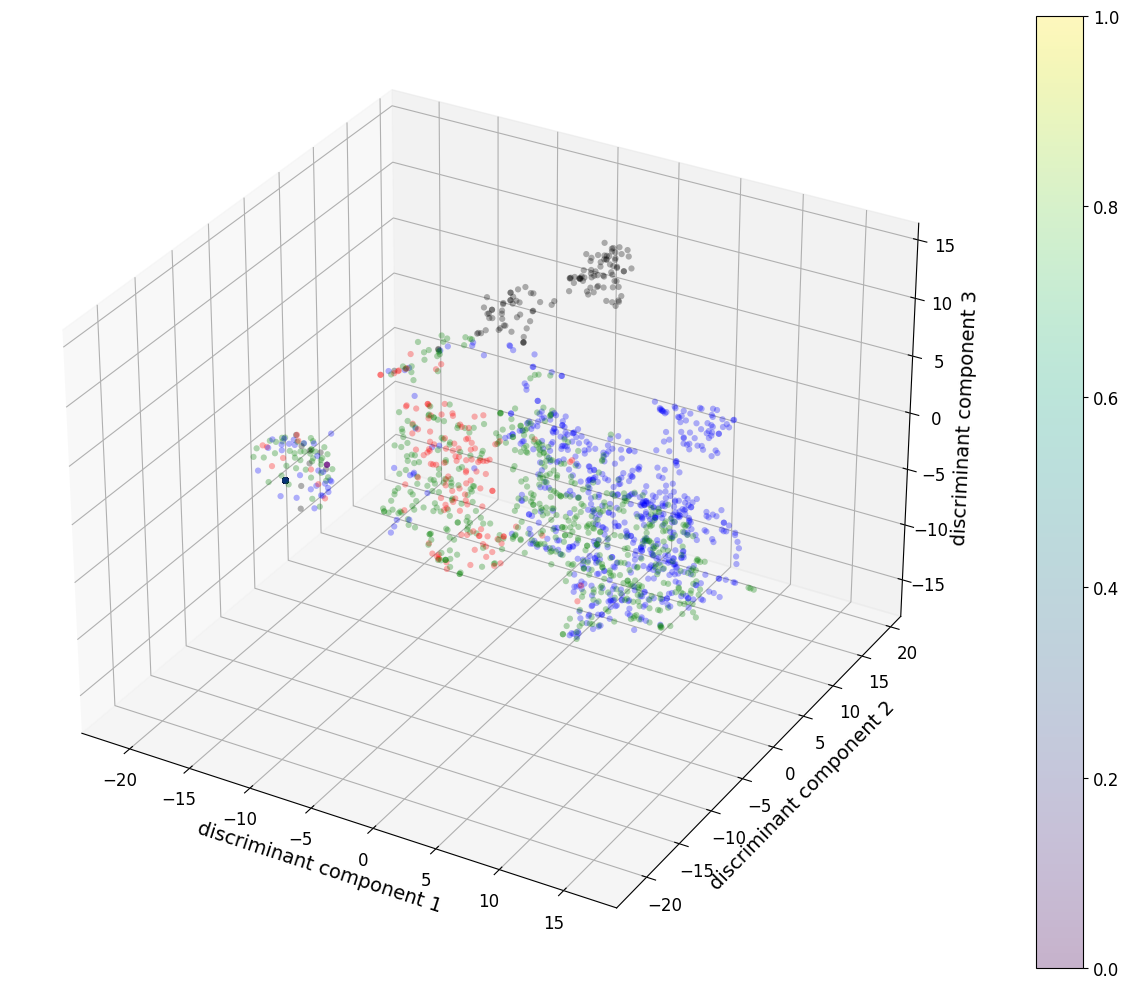

In [30]:
# Plot the feature space with position colored
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
p=ax.scatter3D(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
               c=y_train.map({0:'blue',1:'r',2:'black', 3:'g'}), edgecolor='none', alpha=0.3)
ax.set_xlabel('discriminant component 1')
ax.set_ylabel('discriminant component 2')
ax.set_zlabel('discriminant component 3')
plt.colorbar(p)
save_fig("tsne_feature_space")

**NOTE:** The result seems not as promissing as the former.

## 4 - Isomap

In [17]:
# Fit Isomap to the data
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

er = 200
for n_neigh in range(1, 20):
    m = Pipeline([
        ("scaler", StandardScaler()),
        ("dim_reductor", Isomap(n_components=3, n_neighbors=n_neigh))
    ])
    X_iso = m.fit_transform(X_train)
    if m["dim_reductor"].reconstruction_error() < er:
        isomap = m
        er = isomap["dim_reductor"].reconstruction_error()
er

18.6592243419656

In [20]:
# Transform data with best checkpoint
X_iso = isomap.fit_transform(X_train)
isomap

Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_reductor', Isomap(n_components=3, n_neighbors=19))])

Saving figure isomap_feature_space


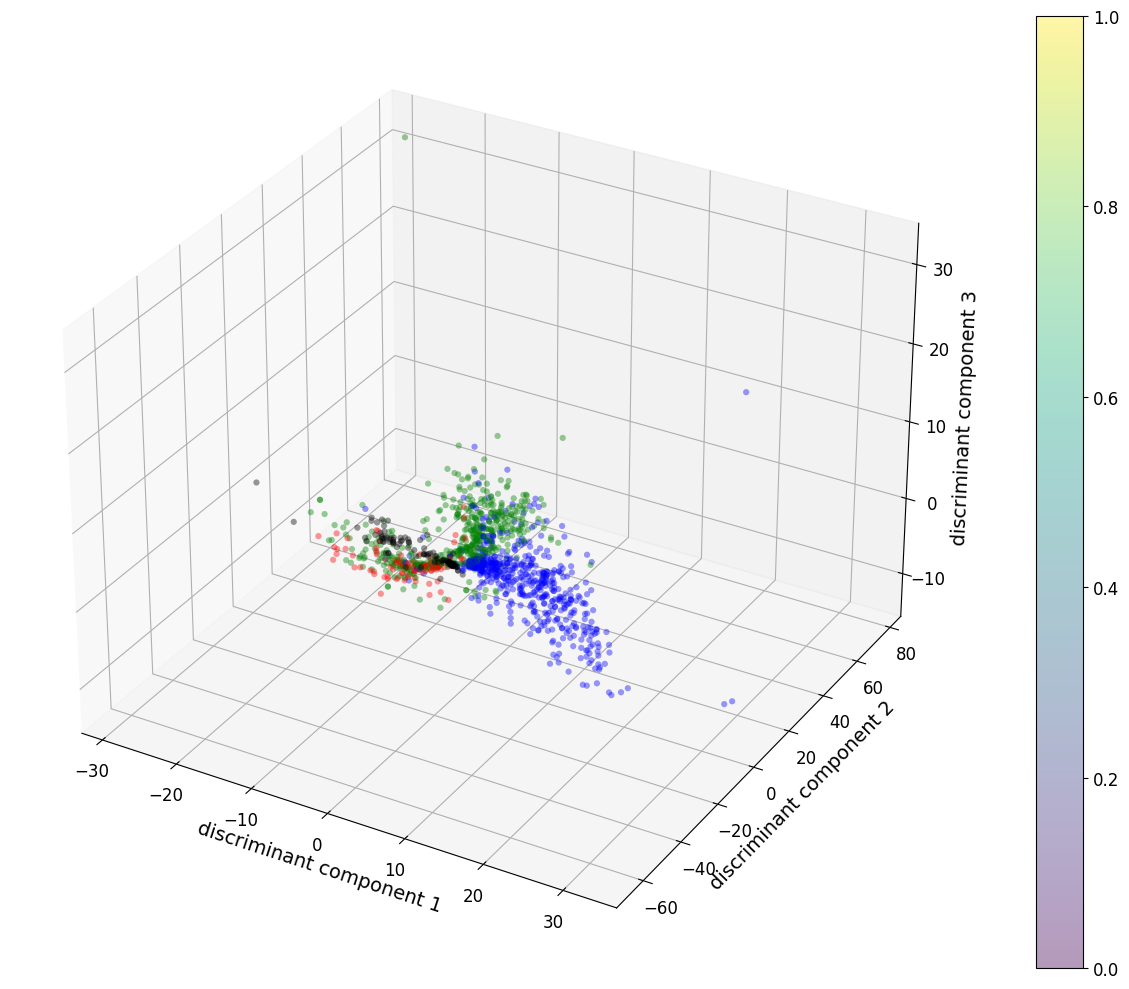

In [21]:
# Plot the feature space with position colored
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
p=ax.scatter3D(X_iso[:, 0], X_iso[:, 1], X_iso[:, 2],
               c=y_train.map({0:'blue',1:'r',2:'black', 3:'g'}), edgecolor='none', alpha=0.4)
ax.set_xlabel('discriminant component 1')
ax.set_ylabel('discriminant component 2')
ax.set_zlabel('discriminant component 3')
plt.colorbar(p)
save_fig("isomap_feature_space")

## 5 - Multidimensional Scaling

In [8]:
# Fit MDS to the data
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mds = Pipeline([
    ("scaler", StandardScaler()),
    ("dim_reductor", MDS(n_components=3, normalized_stress='auto'))
])
X_mds = mds.fit_transform(X_train) # very slow
mds["dim_reductor"].stress_

2046929.7161769385

Saving figure mds_feature_space


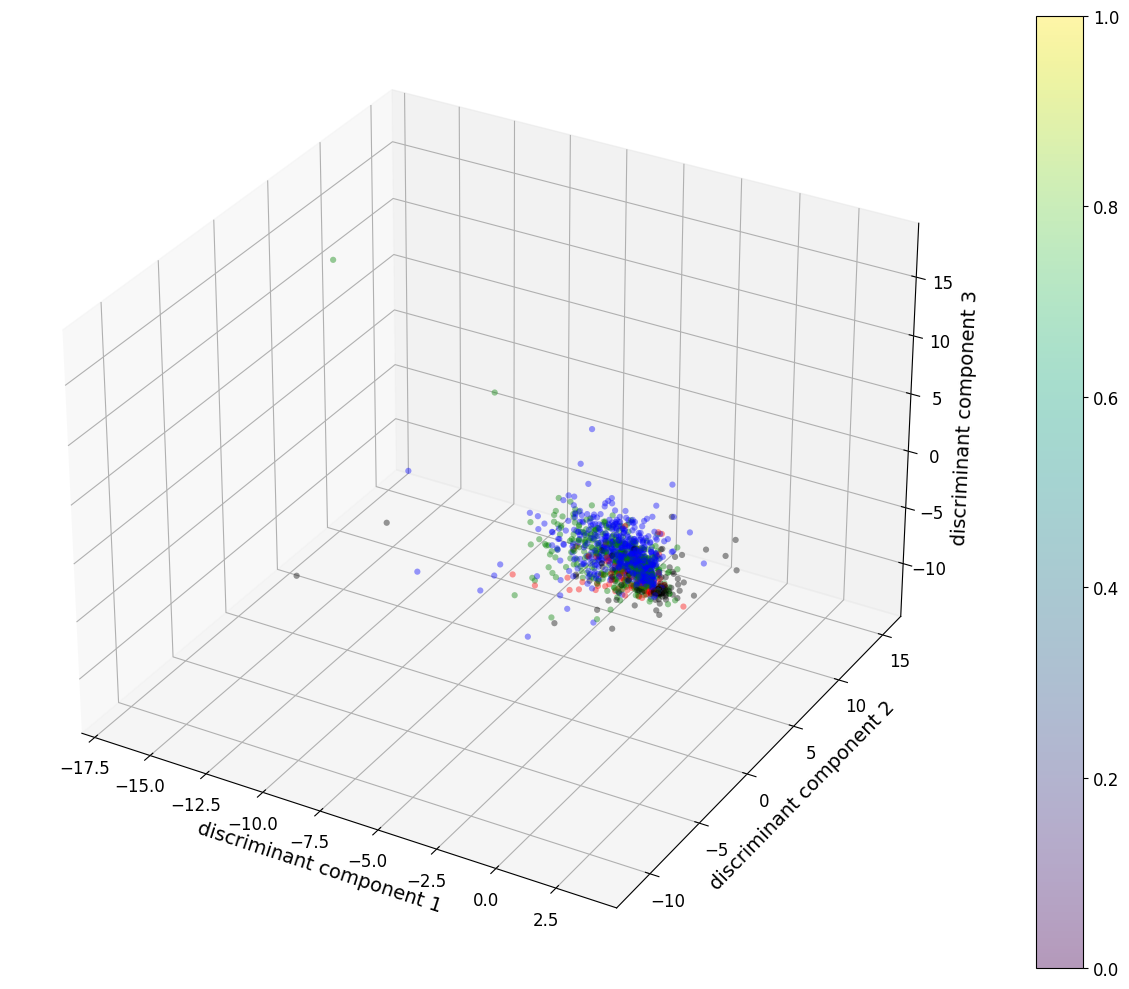

In [29]:
# Plot the feature space with position colored
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
p=ax.scatter3D(X_mds[:, 0], X_mds[:, 1], X_mds[:, 2],
               c=y_train.map({0:'blue',1:'r',2:'black', 3:'g'}), edgecolor='none', alpha=0.4)
ax.set_xlabel('discriminant component 1')
ax.set_ylabel('discriminant component 2')
ax.set_zlabel('discriminant component 3')
plt.colorbar(p)
save_fig("mds_feature_space")

**NOTE:** Both fit time and stress are large. As observed, the stress reduces when `n_components` increases. However, in order to achieve the acceptable stress (below 1.0), the number of components is by far over 24, which even surpasses that of PCA. Therefore, MDS is not a good choice, in our opinion.

## 6 - Factor Analysis

In [31]:
# Fit FA to the data
from sklearn.decomposition import FactorAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

best_score = -10e9
for n_comp in range(1, 25):
    m = Pipeline([
        ("scaler", StandardScaler()),
        ("dim_reductor", FactorAnalysis(n_components=n_comp, random_state=42))
    ])
    X_fa = m.fit_transform(X_train, y_train)
    score = m["dim_reductor"].score(X_test, y_test)
    if score > best_score:
        fa = m
        best_score = score
fa

Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_reductor',
                 FactorAnalysis(n_components=1, random_state=42))])

Saving figure fa_feature_space


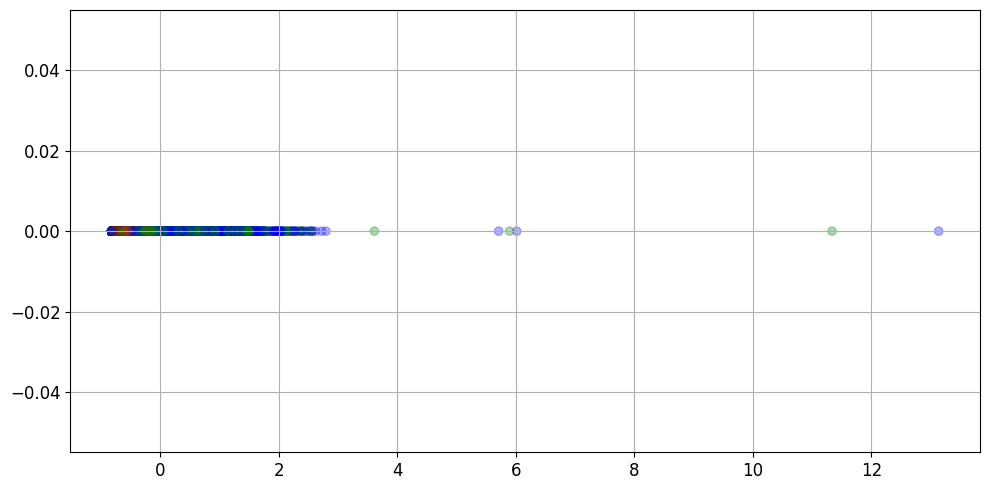

In [44]:
# Plot the feature space with position colored 
X_fa = fa.transform(X_train)
plt.figure(figsize=(10, 5))
plt.scatter(X_fa, np.zeros(len(X_fa)), c=y_train.map({0:'blue',1:'r',2:'black', 3:'g'}), alpha=0.3)
plt.grid()
plt.tight_layout()
save_fig("fa_feature_space")

**NOTE:** Factor analysis does not look promissing.